# Lesson 06 - Hyperparameters tuning with talos

Talos (https://github.com/autonomio/talos) is one of the libraries allowing to optimize hyperparameters of ANN models. It is designed to complement Keras. Before you proceed further, please install the library.

In [1]:
import talos as ta

C:\Users\user\Anaconda3\envs\ml\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np


import sklearn

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler, RobustScaler

from keras.models import Model
from keras.optimizers import Adam
from keras.layers import TimeDistributed, GlobalAveragePooling1D, Activation, Input, LSTM, GRU, Dense, Dropout, Flatten, Embedding, SpatialDropout1D, Bidirectional, CuDNNGRU
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers import Flatten, concatenate
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, activations
from keras.layers.recurrent import Recurrent
from keras.engine import InputSpec
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, CSVLogger

import tensorflow as tf
from tensorflow import set_random_seed
from keras import backend as K

# This part required only for GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.allocator_type = 'BFC'
sess = tf.Session(config=config)
K.set_session(sess)


seed = 10293239

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## Load data and basic info

Let's load the same dataset as in Lesson 01.

In [4]:
bugs = pd.read_csv('./data/bugs_train.csv', parse_dates=['Opened', 'Changed'], index_col=None)

In [5]:
bugs.head(4)

,Component,Assignee,Status,Summary,Opened,Changed,Priority,Severity,Resolution
0,Debug,eclipse,VERIFIED,Icons needed for actions (1GI5UXW),2001-10-10 22:14:41,2001-10-18 11:51:14,P1,enhancement,FIXED
1,Debug,darin.eclipse,RESOLVED,README: Hit count not reset (1GET20Y),2001-10-10 22:14:42,2001-11-28 13:42:46,P3,normal,WORKSFORME
2,Debug,darin.eclipse,CLOSED,Use styled text in console (1G9S1YF),2001-10-10 22:14:43,2002-06-26 11:32:05,P3,normal,WONTFIX
3,Debug,eclipse,VERIFIED,StringBuffer representation (1GE3BFA),2001-10-10 22:14:44,2014-12-02 06:37:26,P3,normal,FIXED


## The classification task (the problem to solve)

Our task remains the same for this lesson - we would be to predict what will be the resolution of the defect report (y) based on the description of a defect (X). 

## Data preparation (features)

Let's quickly replicate processing of the Component and Severity features, as well as converting the decision class.

In [6]:
# we will make a copy of the main data
bugs_small = bugs[["Assignee", "Component", "Severity", "Status", "Priority", "Opened", "Changed", "Summary", "Resolution"]]

# Component
bugs_small = pd.get_dummies(bugs_small, columns=['Component'], prefix="Component")

# Severity
bugs_small['Severity'] = bugs_small['Severity'].map(
    {'enhancement':0, 'trivial':1, 'minor':2, 'normal':3, 'major':4, 'critical':5, 'blocker':6})

# Status
bugs_small['Status'] = bugs_small['Status'].map(
    {'VERIFIED':0, 'RESOLVED':1, 'CLOSED':2})

# Priority
bugs_small['Priority'] = bugs_small['Priority'].map(
    {'P1':1, 'P2':2, 'P3':3, 'P4':4, 'P5':5})


y = bugs_small['Resolution']
X = bugs_small.drop(['Resolution'], axis=1, inplace=False)


# Days
X['Days'] = X.apply(lambda x: (x.Changed - x.Opened).days, axis=1)
X.drop(["Changed", "Opened"], inplace=True, axis=1)

# Summary as BoW
X['Summary'] = X['Summary'].fillna('')
from sklearn.feature_extraction.text import CountVectorizer

# create CountVectorizer class; we take only 30 most frequently appearing features
count_vect = CountVectorizer(max_features=30, stop_words="english")

# CountVectorizer fit method extracts vocabulary while transform performs the transformation. There is also
# the method fit_transform that does both.
bag_of_words = count_vect.fit_transform(list(X['Summary'])).todense()

# We create a list of names of columns 
colnames = ["Summary_"+x for x in sorted(count_vect.vocabulary_.keys())]

# Finally, we create a dataframe with bag of words features
summary_bow = pd.DataFrame(bag_of_words, columns=colnames)
X = pd.concat([X.reset_index(drop=True), summary_bow], axis=1)
X.drop(["Summary"], inplace=True, axis=1)

# Assignee
inbox = [1 if x.endswith('-inbox') else 0 for x in bugs_small['Assignee']]
X.insert(loc=0, column='Assignee_Inbox', value=pd.Series(inbox))
    
eclipse = [1 if x.endswith('eclipse') else 0 for x in bugs_small['Assignee']]
X.insert(loc=0, column='Assignee_Eclipse', value=pd.Series(eclipse))
X.drop(["Assignee"], inplace=True, axis=1)


In [7]:
X.head(4)

,Assignee_Eclipse,Assignee_Inbox,Severity,Status,Priority,Component_APT,Component_Core,Component_Debug,Component_Doc,Component_Text,...,Summary_npe,Summary_package,Summary_project,Summary_quick,Summary_refactoring,Summary_search,Summary_source,Summary_type,Summary_view,Summary_work
0,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,3,1,3,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,3,2,3,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,3,0,3,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's simplify the problem to binary classification => resulolution FIXED, NOT FIXED

In [8]:
y_binary = np.array([1 if x == "FIXED" else 0 for x in y])
y_binary

array([1, 0, 0, ..., 0, 0, 0])

## Optimize hyperparameters using talos

In the previous lesson, we built a simple ANN for the considered problem. We will use talos to systematically search through the space of hyperparameters. 

### Create a template function for model creation

Talos requires us to prepare a template function that will train and return a model. One of the parameters of is a dictionary containing parameters to be used while creating the model.


In [9]:
def get_model(x_train, y_train, x_val, y_val, params):
    
    global seed
    np.random.seed(seed)
    set_random_seed(seed)
    
    main_input = Input(shape=(params['n_features'],), name='input')
    model = main_input
    for layer in params['layers']:
        model = Dense(layer['n'], activation="relu")(model)
    model = Dropout(params['dropout'])(model)  
    output = Dense(1, activation="sigmoid")(model)
    
    model = Model([main_input] , output)
    algorithm = Adam(lr=0.005, beta_1=0.95, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=algorithm, loss='binary_crossentropy', metrics=['accuracy'])
    
    callbacks_list = [
        ReduceLROnPlateau( 
            monitor='loss',
            min_lr=0.001,
            factor=0.5,
            verbose=1,
            patience=10), 
    ]
    
    out = model.fit(x_train, y_train,
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    verbose=0,
                    validation_data=[x_val, y_val])
    return out, model

In [24]:
p = {'layers': [
        [{'n' : 20}],
        [{'n' : 20}, {'n' : 20}],
    ], 
    'n_features' : [X.shape[1]],
    'batch_size': [128, 256],
    'epochs': [5, 10, 15],
    'dropout': [0, 0.2, 0.3],
}

In [43]:
scan_obj = ta.Scan(X.values, y_binary, 
            params=p,
            model=get_model,
            experiment_name='Experiment_1',
            seed = seed,
            val_split=0.33,
            fraction_limit=0.2)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:25<00:00, 11.62s/it]


In [47]:
report = ta.Reporting(scan_obj)

In [48]:
report.data.sort_values('val_acc', ascending=False)

,round_epochs,val_loss,val_acc,loss,acc,batch_size,dropout,epochs,layers,n_features
6,15,0.388998,0.827842,0.398937,0.822756,256,0.0,15,[{'n': 20}],42
2,10,0.419502,0.811985,0.448793,0.790769,128,0.2,10,[{'n': 20}],42
4,15,0.429356,0.804778,0.433473,0.802502,128,0.2,15,"[{'n': 20}, {'n': 20}]",42
3,10,0.574382,0.803817,0.397897,0.823026,128,0.0,10,"[{'n': 20}, {'n': 20}]",42
5,10,0.441167,0.803062,0.455866,0.789721,256,0.2,10,"[{'n': 20}, {'n': 20}]",42
0,5,0.444177,0.797776,0.462445,0.781775,256,0.2,5,"[{'n': 20}, {'n': 20}]",42
1,10,0.957457,0.770799,0.428191,0.819341,128,0.0,10,[{'n': 20}],42


In [49]:
report.correlate('val_acc')

batch_size    0.365028
dropout       0.111576
epochs        0.450218
n_features         NaN
Name: val_acc, dtype: float64

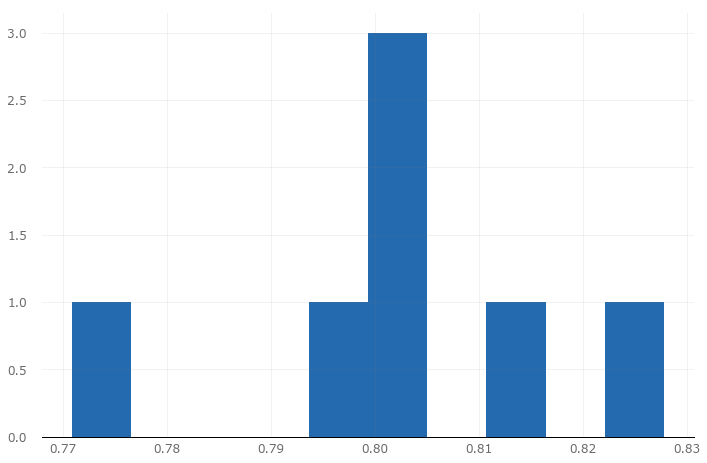

In [52]:
report.plot_hist('val_acc', bins=10)

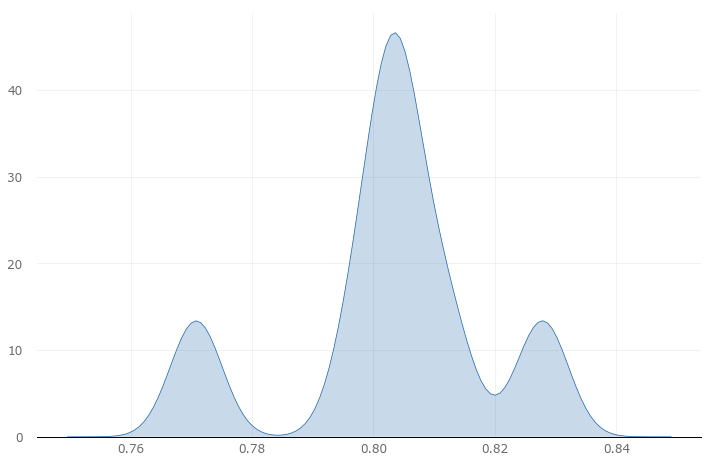

In [50]:
report.plot_kde('val_acc')